In [30]:
import matplotlib.pyplot as plt
from pprint import pprint
import docker
import sortingview

In [2]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

In [3]:
# global arguments for parallel processing
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [4]:
# download data
local_path = si.download_dataset(remote_path='mearec/mearec_test_10s.h5')
recording, sorting_true = se.read_mearec(local_path)
print(recording)
print(sorting_true)

MEArecRecordingExtractor: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
  file_path: C:\Users\jsher\spikeinterface_datasets\ephy_testing_data\mearec\mearec_test_10s.h5
MEArecSortingExtractor: 10 units - 1 segments - 32.0kHz
  file_path: C:\Users\jsher\spikeinterface_datasets\ephy_testing_data\mearec\mearec_test_10s.h5


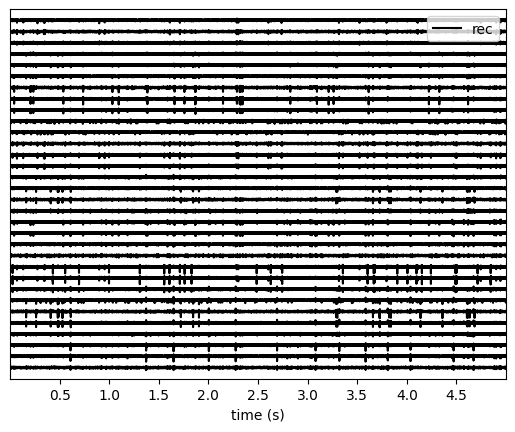

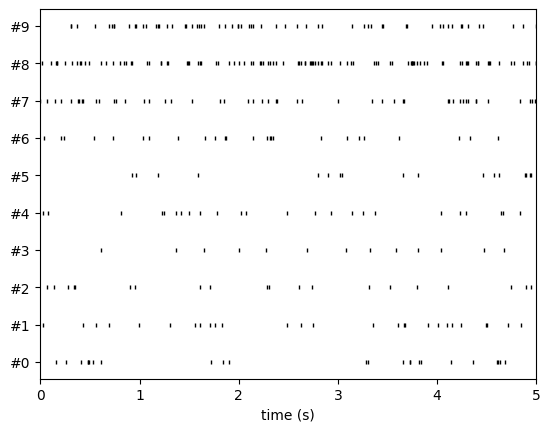

In [5]:
# plot sample data using traces and raster plots
w_ts = sw.plot_traces(recording, time_range=(0,5))
w_rs = sw.plot_rasters(sorting_true, time_range=(0,5))

In [6]:
# retrieve info from base recording
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

# channels are individual electrodes, in this there are 32 electrodes recording signals in the brain
print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1


In [7]:
unit_ids = sorting_true.get_unit_ids()
spike_train = sorting_true.get_unit_spike_train(unit_id=unit_ids[0])

# unit ids of neurons, and what time they fired
print('Unit ids:', unit_ids)
print('Spike train of first unit:', spike_train)

Unit ids: ['#0' '#1' '#2' '#3' '#4' '#5' '#6' '#7' '#8' '#9']
Spike train of first unit: [  5197   8413  13124  15420  15497  15668  16929  19607  55107  59060
  60958 105193 105569 117082 119243 119326 122293 122877 132413 139498
 147402 147682 148271 149857 165454 170569 174319 176237 183598 192278
 201535 217193 219715 221226 222967 223897 225338 243206 243775 248754
 253184 253308 265132 266197 266662 283149 284716 287592 304025 305286
 310438 310775 318460]


Probe - 32ch - 1shanks


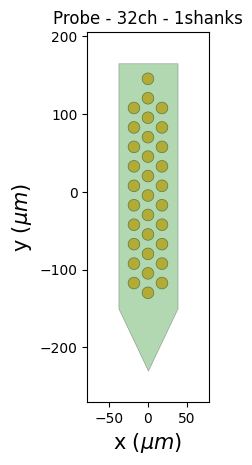

In [8]:
# visualize probe that goes inside brain and records signals
probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

_ = plot_probe(probe)

In [9]:
# preprocessing for building pipelines
recording_cmr = recording

# bandpass filter to allow only signals between 300-6000Hz (most informative)
recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)

# common median reference -> remove background noise thats common to all recording channels
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')
print(recording_cmr)

# only happen when we speically ask for processed data or save it
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

BandpassFilterRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                         float32 dtype - 39.06 MiB
CommonReferenceRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
Use cache_folder=C:\Users\jsher\AppData\Local\Temp\spikeinterface_cache\tmp229qgg32\SYZIH2J3
write_binary_recording with n_jobs = 4 and chunk_size = 32000


write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

BinaryFolderRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                       float32 dtype - 39.06 MiB


In [10]:
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['spykingcircus2', 'tridesclous2']


In [11]:
print("Tridesclous2 params:")
pprint(ss.get_default_sorter_params('tridesclous2'))
print("SpykingCircus2 params:")
pprint(ss.get_default_sorter_params('spykingcircus2'))

Tridesclous2 params:
{'apply_preprocessing': True,
 'clustering': {'merge_radius_um': 40.0, 'split_radius_um': 40.0},
 'detection': {'detect_threshold': 5,
               'exclude_sweep_ms': 1.5,
               'peak_sign': 'neg',
               'radius_um': 150.0},
 'features': {},
 'filtering': {'freq_max': 12000.0, 'freq_min': 300.0},
 'job_kwargs': {'n_jobs': -1},
 'matching': {'peak_shift_ms': 0.2, 'radius_um': 100.0},
 'save_array': True,
 'selection': {'min_n_peaks': 20000, 'n_peaks_per_channel': 5000},
 'svd': {'n_components': 6},
 'templates': {'ms_after': 2.5, 'ms_before': 1.5},
 'waveforms': {'ms_after': 1.5, 'ms_before': 0.5, 'radius_um': 120.0}}
SpykingCircus2 params:
{'apply_preprocessing': True,
 'clustering': {},
 'detection': {'detect_threshold': 5, 'peak_sign': 'neg'},
 'filtering': {'dtype': 'float32', 'freq_min': 150},
 'general': {'ms_after': 2, 'ms_before': 2, 'radius_um': 100},
 'job_kwargs': {'n_jobs': -1},
 'localization': {},
 'matching': {},
 'selection': {'m

Trid2 params
- Apply preprocessing - Whether to clean up data before sorting
- Clustering - grouping spikes based on similarities (distance measures)
- Detection - Settings for identifying spikes, how strong they must be and which direction they should go
- Filtering - focuses on specific frequencies in the data
- Job kwards - how many tasks done at once
- Matching - helps in aligning spikes based on time shift and distance
- Selection - Decides how many spikes are needed to consider neuron alive
- Waveforms - Defines time window around each spike for analysis

In [12]:
# sort using trid2 sorting algorithm
sorting_TDC = ss.run_sorter(sorter_name='tridesclous2', recording=recording_preprocessed)
print(sorting_TDC)

ValueError: Folder C:\Users\jsher\spike_interface\tridesclous2_output already exists

In [17]:
# sort using spykingcircus2, for some reason hdbscan is not registering
sorting_SC2 = ss.run_sorter(sorter_name="spykingcircus2", recording=recording_preprocessed)
print(sorting_SC2)

NumpyFolderSorting: 10 units - 1 segments - 32.0kHz


In [18]:
print('Units spyking2:', sorting_SC2.get_unit_ids())

Units spyking2: [0 1 2 3 4 5 6 7 8 9]


In [19]:
# wave forms - like a drawing that shows how neurons spike looks over a short time, each a unique shape
wv_sp2 = si.extract_waveforms(recording_preprocessed, sorting_SC2, 'waveforms_folder', overwrite=True)
print(wv_sp2)

extract waveforms shared_memory multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]

WaveformExtractor: 32 channels - 10 units - 1 segments
  before:32 after:64 n_per_units:500 - sparse


In [20]:
unit_id0 = sorting_SC2.unit_ids[0]
waveforms = wv_sp2.get_waveforms(unit_id0)
print(waveforms.shape)

template = wv_sp2.get_template(unit_id0)
print(template.shape)

(30, 96, 20)
(96, 20)


In [21]:
# postprocessing
amplitudes = spost.compute_spike_amplitudes(wv_sp2)
unit_locations = spost.compute_unit_locations(wv_sp2)
spike_locations = spost.compute_spike_locations(wv_sp2)
correleograms,bins = spost.compute_correlograms(wv_sp2)
similarity = spost.compute_template_similarity(wv_sp2)

extract amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/10 [00:00<?, ?it/s]

- Amplitudes - how big or strong each spike is
- Unit locations - where each neuron is located
- Spike locations - Where each spike happened
- Correlograms - How spikes from different neurons related over time
- Similarity - How similar the spike shapes are from different neurons

In [22]:
print('amplitudes:',amplitudes)
print('unit locations:', unit_locations)
print('spike locations:',spike_locations)
print('correleograms:',correleograms)
print('bins:',bins)
print('similarity:',similarity)

amplitudes: [array([-122.13814 , -112.33482 , -308.51724 ,  -83.323044, -267.80325 ,
        -91.180954, -179.80661 ,  -97.97978 ,  -97.59325 , -159.0577  ,
        -92.715324, -102.85024 , -256.23724 ,  -96.82832 ,  -89.65219 ,
       -274.44498 , -106.947945, -232.02353 ,  -95.23263 , -265.50327 ,
       -141.965   , -132.04079 , -104.449844, -124.39531 ,  -80.02431 ,
       -167.61151 , -173.9343  , -147.19138 ,  -96.332184, -112.69296 ,
        -75.2477  , -110.152664, -314.45184 ,  -81.4216  , -120.99451 ,
        -80.86165 , -335.7069  , -101.752716, -287.91193 , -312.31006 ,
       -246.10635 ,  -93.42082 , -304.34726 , -271.83215 , -122.398125,
       -314.99316 , -124.79295 ,  -87.05478 , -112.706   , -301.32037 ,
       -257.60223 ,  -89.80943 , -141.06116 , -275.87112 , -138.96153 ,
       -137.5569  , -303.1844  ,  -86.51811 , -120.94319 , -126.22918 ,
        -95.59357 , -103.111084, -101.25032 ,  -90.96587 ,  -89.591866,
        -94.66259 , -126.93658 , -166.86847 , -100.

        -94.42335 , -117.719955], dtype=float32)]
unit locations: [[ -28.99613938  -80.5172291     2.29170842]
 [  -2.958152    -44.89990403    8.40449249]
 [  33.95512337  -66.23779871    4.57809625]
 [  12.10462454 -125.16937276    1.07211063]
 [   0.71664445 -100.08123734   29.33497522]
 [   4.67850762  139.82459713    3.06362961]
 [ -19.08844766   -0.86528926    5.60976477]
 [ -14.50056542   38.5476914     1.        ]
 [  -2.38549265  102.19954362   19.24209589]
 [ -23.19713187   97.38988361    1.        ]]
spike locations: [( 5.49731330e-01,  112.09294289) ( 3.90403005e+00,  -99.61885985)
 (-7.59935928e+00,   94.79055391) (-8.51129478e-01,  -32.9812489 )
 ( 4.67408186e+00,  -68.36749543) ( 6.82585656e-01,  114.66128877)
 (-3.82198654e-01,   90.76594531) ( 4.72540063e-01,  -36.80754412)
 ( 2.52385379e+00, -100.8740527 ) (-1.05194402e+00,   92.08300711)
 ( 9.84598841e-01,  115.82922161) ( 3.74916732e+00,  -98.16185795)
 (-5.15206430e+00,    3.00940983) ( 2.59285471e+00,  -98.0141996

 ( 2.98633158e+00,  -99.90211919)]
correleograms: [[[0 0 0 ... 0 0 0]
  [0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]
  ...
  [0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 0]
  [0 1 0 ... 0 0 0]
  ...
  [0 0 1 ... 0 0 1]
  [1 0 0 ... 1 1 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 0 0 ... 0 1 0]
  [0 1 0 ... 0 1 0]
  ...
  [0 0 0 ... 3 0 0]
  [0 0 0 ... 0 1 0]
  [0 1 0 ... 0 0 1]]

 ...

 [[1 0 0 ... 0 0 0]
  [1 0 0 ... 1 0 0]
  [0 0 3 ... 0 0 0]
  ...
  [0 3 1 ... 1 3 0]
  [0 0 1 ... 1 1 0]
  [2 0 0 ... 0 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 1 1 ... 0 0 1]
  [0 1 0 ... 0 0 0]
  ...
  [0 1 1 ... 1 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 1 0]
  ...
  [1 1 0 ... 0 0 2]
  [0 0 0 ... 0 0 1]
  [0 0 1 ... 1 0 0]]]
bins: [-25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12.
 -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   

In [23]:
print(wv_sp2.get_available_extension_names())

['similarity', 'spike_amplitudes', 'correlograms', 'spike_locations', 'unit_locations']


In [24]:
# compute quality metrics
qm_params = sqm.get_default_qm_params()
pprint(qm_params)

{'amplitude_cutoff': {'amplitudes_bins_min_ratio': 5,
                      'histogram_smoothing_value': 3,
                      'num_histogram_bins': 100,
                      'peak_sign': 'neg'},
 'amplitude_cv': {'amplitude_extension': 'spike_amplitudes',
                  'average_num_spikes_per_bin': 50,
                  'min_num_bins': 10,
                  'percentiles': (5, 95)},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'direction': 'y',
           'interval_s': 60,
           'min_num_bins': 2,
           'min_spikes_per_interval': 100},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'nearest_neighbor': {'max_spikes': 10000, 'n_neighbors': 5},
 'nn_isolation': {'max_spikes': 10000,
                  'min_fr': 0.0,
                  'min_spikes': 10,
                  'n_components': 10,
                  'n_neighbors': 4,
                  'peak_sign': 'neg',
                  'radius_u

In [25]:
# modify paramaters to accomodate short duration
qm_params["presence_ratio"]["bin_duration_s"] = 1
qm_params["amplitude_cutoff"]["num_histogram_bins"] = 5
qm_params["drift"]["interval_s"] = 2
qm_params["drift"]["min_spikes_per_interval"] = 2

In [27]:
qm = sqm.compute_quality_metrics(wv_sp2, qm_params=qm_params)
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,30.0,3.0,0.9,27.373295,0.0,0,0.0,0,NaN,0.500000,307.199036,NaN,NaN,0.0,0.0,0.0,0.72,1.052532,0.424653,0.421992
1,48.0,4.8,1.0,8.306600,0.0,0,0.0,0,NaN,0.202432,92.216766,NaN,NaN,0.0,0.0,0.0,0.00,2.052322,0.755333,0.439007
2,51.0,5.1,1.0,24.226444,0.0,0,0.0,0,NaN,0.500000,275.647156,NaN,NaN,0.0,0.0,0.0,0.18,0.995004,0.350696,0.289678
3,195.0,19.5,1.0,8.796578,0.0,0,0.0,0,0.155,0.500000,103.211884,NaN,NaN,0.0,0.0,0.0,1.98,1.191062,0.456159,0.493128
4,37.0,3.7,1.0,9.568769,0.0,0,0.0,0,NaN,0.209085,107.503098,NaN,NaN,0.0,0.0,0.0,0.54,1.941205,0.688704,0.563115
5,111.0,11.1,1.0,8.354827,0.0,0,0.0,0,0.265,0.238090,97.116776,NaN,NaN,0.0,0.0,0.0,2.34,1.346153,0.516522,0.501917
6,53.0,5.3,0.9,24.205545,0.0,0,0.0,0,NaN,0.500000,270.204590,NaN,NaN,0.0,0.0,0.0,0.90,1.355411,0.541736,0.567367
7,129.0,12.9,1.0,11.030790,0.0,0,0.0,0,0.310,0.500000,128.252319,NaN,NaN,0.0,0.0,0.0,0.90,1.174241,0.461305,0.492228
8,43.0,4.3,1.0,13.233472,0.0,0,0.0,0,NaN,0.205061,151.596924,NaN,NaN,0.0,0.0,0.0,0.54,0.845902,0.288917,0.173478
9,50.0,5.0,1.0,26.799688,0.0,0,0.0,0,NaN,0.500000,312.545715,NaN,NaN,0.0,0.0,0.0,0.72,0.344657,0.124482,0.107622


In [31]:
w1 = sw.plot_quality_metrics(wv_sp2, display=False, backend="sortingview")

C:\Users\jsher\AppData\Local\Programs\Python\Python39\lib\site-packages\spikeinterface\widgets\metrics.py:63: UserWarning: Skipping ['amplitude_cv_median', 'amplitude_cv_range'] because they contain all NaNs
  warnings.warn(f"Skipping {nan_metrics} because they contain all NaNs")


Exception: Error in initiateFileUpload (500) Internal Server Error: Error: Client not registered. Use kachery-cloud-init to register this kachery-cloud client.

In [32]:
comp_gt = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_pair = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_SC2)
comp_multi = sc.compare_multiple_sorters(sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2],
                                         name_list=['tdc', 'sc2', 'ks2'])

NameError: name 'sorting_TDC' is not defined